# Problem 1: Little Peak

[BQ-PYTHON-SDK][WARNING] - Beta version 0.12.0b1 of BlueQubit Python SDK is being used.


🔵 BlueQubit initialized successfully

🔍 Analyzing /P1_little_peak.qasm with 10,000 shots
🌀 Loaded 4-qubit circuit with 11 gates
⚡ Using BlueQubit for accelerated execution...
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8Ju79A9Q6kTOHu62, device: cpu, run status: COMPLETED, created on: 2025-04-12 19:17:58 UTC, cost: $0.00, run time: 8 ms, queue time: 102 ms, num qubits: 4


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8Ju79A9Q6kTOHu62, device: cpu, run status: COMPLETED, created on: 2025-04-12 19:17:58 UTC, cost: $0.00, run time: 8 ms, queue time: 102 ms, num qubits: 4


📦 Job submitted (ID: 8Ju79A9Q6kTOHu62)
✅ Completed in 8 ms


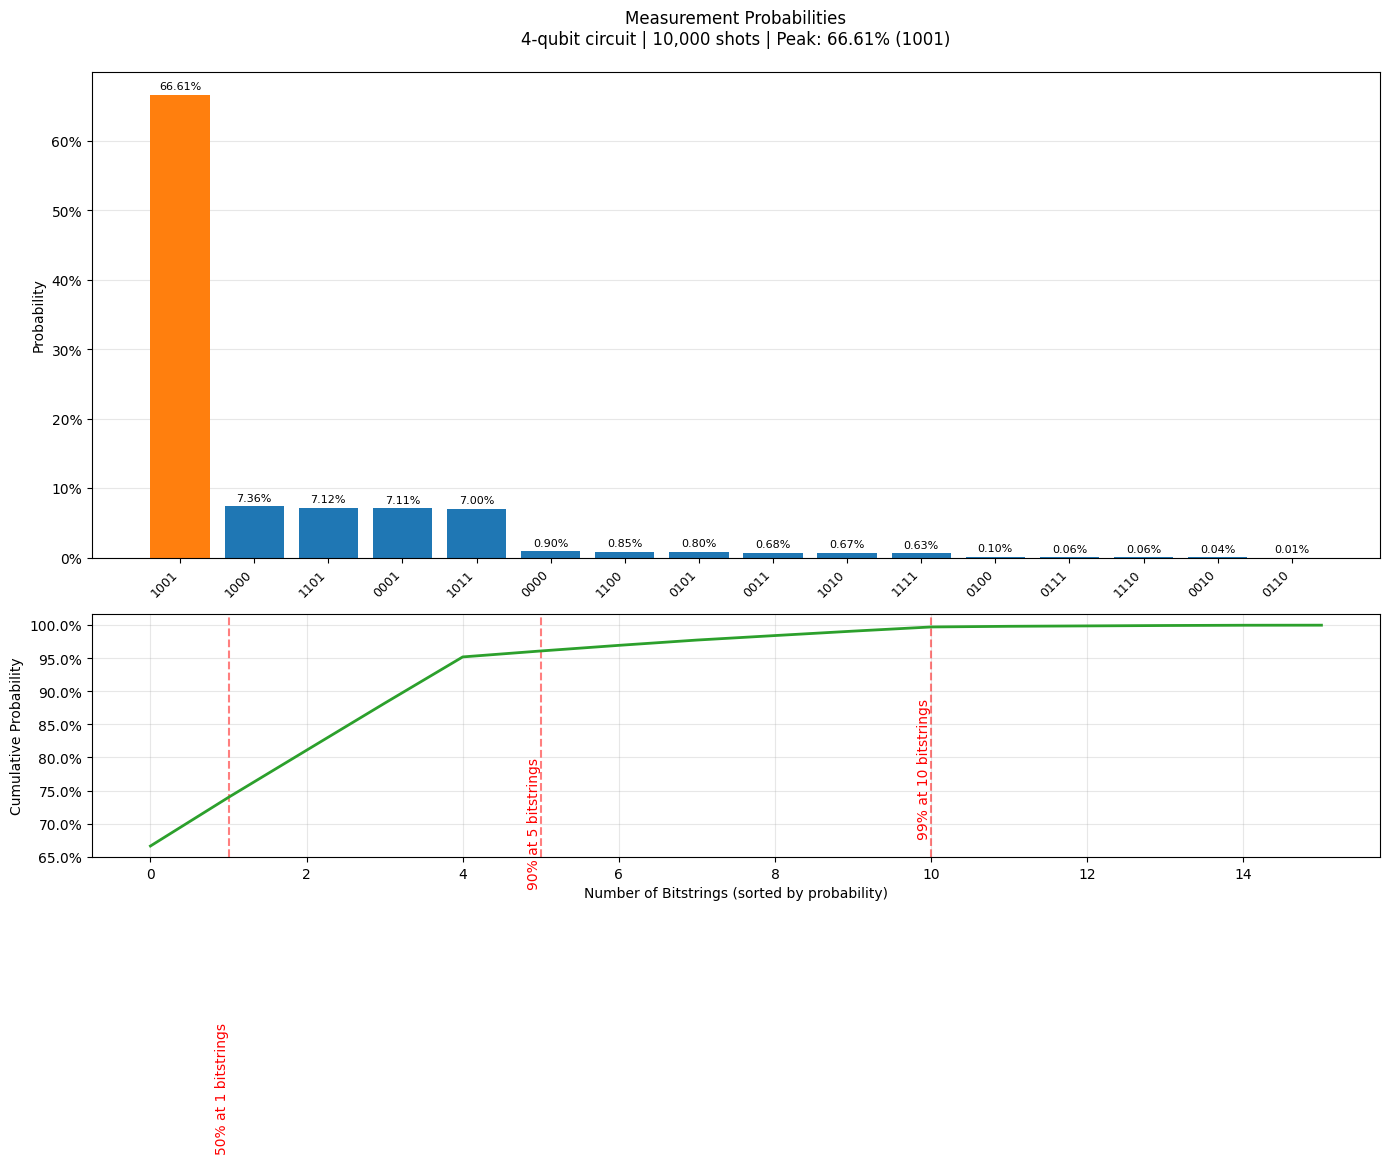


🎯 Found peaked bitstring: 1001 (Probability: 66.61%)

📊 Statistics:
- Total possible outcomes: 16
- Actual observed outcomes: 16
- 50% of probability in first 1 bitstrings
- 90% of probability in first 5 bitstrings
- 99% of probability in first 10 bitstrings

✅ Analysis completed successfully!


In [6]:
import bluequbit
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, List
import time
from matplotlib.ticker import PercentFormatter, FuncFormatter
from datetime import datetime

class QuantumCircuitAnalyzer:
    def __init__(self, bluequbit_token: Optional[str] = None):
        """Initialize analyzer with optional BlueQubit access"""
        self.bq = None
        if bluequbit_token:
            try:
                self.bq = bluequbit.init(bluequbit_token)
                print("🔵 BlueQubit initialized successfully")
            except Exception as e:
                print(f"⚠️ BlueQubit initialization failed: {e}. Using local simulator.")

        self.circuit = None
        self.results = None
        self.job_result = None
        self.probabilities = None

    def _calculate_probabilities(self) -> None:
        """Calculate probabilities from results and sort by probability."""
        if not self.results:
            raise ValueError("No results available to calculate probabilities")

        # Calculate total shots
        total_shots = sum(self.results.values())

        # Convert counts to probabilities
        probabilities = {
            bitstring: count / total_shots
            for bitstring, count in self.results.items()
        }

        # Sort by probability in descending order
        self.probabilities = sorted(
            probabilities.items(),
            key=lambda x: x[1],
            reverse=True
        )

    def load_qasm_circuit(self, qasm_file_path: str) -> QuantumCircuit:
        """Load and prepare quantum circuit from QASM file"""
        self.circuit = QuantumCircuit.from_qasm_file(qasm_file_path)

        # Check for existing measurements using count_ops
        if 'measure' not in self.circuit.count_ops():
            self.circuit.measure_all()

        print(f"🌀 Loaded {self.circuit.num_qubits}-qubit circuit with {len(self.circuit)} gates")
        return self.circuit

    def execute_circuit(self, shots: int = 10000, device: str = 'cpu') -> Dict[str, float]:
        """Execute circuit on BlueQubit or local simulator"""
        if self.bq:
            print("⚡ Using BlueQubit for accelerated execution...")
            self.job_result = self.bq.run(self.circuit, device=device, shots=shots)
            print(f"📦 Job submitted (ID: {self.job_result.job_id})")

            timeout = 600  # 10 minutes for large circuits
            start_time = time.time()
            poll_interval = 5  # Start with a smaller interval

            while not self.job_result.ok:
                current_time = datetime.utcnow().strftime('%H:%M:%S UTC')
                print(f"🕒 {current_time} - Waiting for job completion... "
                      f"Estimated runtime: {self.job_result.estimated_runtime / 1000:.1f}s")

                if time.time() - start_time > timeout:
                    raise TimeoutError("Job execution timed out")

                time.sleep(poll_interval)
                poll_interval = min(poll_interval * 2, 30)  # Exponential backoff up to 30 seconds
                # Refresh job status
                self.job_result = self.bq.get_job(self.job_result.job_id)

            print(f"✅ Completed in {self.job_result.run_time_ms} ms")
            self.results = self.job_result.get_counts()
        else:
            print("⚙️ Using local Qiskit simulator...")
            from qiskit_aer import AerSimulator
            simulator = AerSimulator()
            job = simulator.run(self.circuit, shots=shots)
            self.results = job.result().get_counts()

        self._calculate_probabilities()
        return self.results

    def analyze_distribution(self, confidence: float = 0.5) -> Tuple[Optional[str], float]:
        """Analyze the probability distribution for significant peaks"""
        if not self.probabilities:
            raise ValueError("No results available")

        max_bitstring, max_prob = self.probabilities[0]

        if len(self.probabilities) > 1:
            second_prob = self.probabilities[1][1]
            if (max_prob - second_prob) >= (1 - confidence):
                return max_bitstring, max_prob

        return None, max_prob

    def visualize_results(self, top_n: int = 15) -> None:
        """Create comprehensive visualization of results"""
        if not self.probabilities:
            raise ValueError("No results to visualize")

        total_shots = sum(self.results.values())
        peak_bitstring, peak_prob = self.analyze_distribution()

        # Precompute data for plotting
        top_bitstrings = [p[0] for p in self.probabilities[:top_n]]
        top_probs = [p[1] for p in self.probabilities[:top_n]]
        colors = ['#1f77b4'] * top_n
        if peak_bitstring and peak_bitstring in top_bitstrings:
            peak_idx = top_bitstrings.index(peak_bitstring)
            colors[peak_idx] = '#ff7f0e'

        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12),
                                       gridspec_kw={'height_ratios': [2, 1]})

        # Main probability plot
        bars = ax1.bar(top_bitstrings, top_probs, color=colors)
        ax1.set_xticks(range(len(top_bitstrings)))
        ax1.set_xticklabels(top_bitstrings, rotation=45, ha='right', fontsize=9)
        ax1.set_ylabel('Probability', fontsize=10)

        # Add probability labels
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2., height + 0.005,
                     f'{height:.2%}', ha='center', va='bottom', fontsize=8)

        ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
        title_text = (f"Measurement Probabilities\n"
                      f"{self.circuit.num_qubits}-qubit circuit | {total_shots:,} shots | "
                      f"Peak: {peak_prob:.2%}" +
                      (f" ({peak_bitstring})" if peak_bitstring else ""))
        ax1.set_title(title_text, pad=20)
        ax1.grid(axis='y', alpha=0.3)
        ax1.set_axisbelow(True)

        # Cumulative probability plot
        all_probs = [p[1] for p in self.probabilities]
        cumulative = np.cumsum(all_probs)

        thresholds = {0.5: '50%', 0.9: '90%', 0.99: '99%'}
        for thresh, label in thresholds.items():
            idx = np.argmax(cumulative >= thresh) + 1
            ax2.axvline(idx, color='r', linestyle='--', alpha=0.5)
            ax2.text(idx, thresh - 0.1, f"{label} at {idx} bitstrings",
                     rotation=90, va='top', ha='right', color='r')

        ax2.plot(cumulative, color='#2ca02c', linewidth=2)
        ax2.set_xlabel('Number of Bitstrings (sorted by probability)', fontsize=10)
        ax2.set_ylabel('Cumulative Probability', fontsize=10)
        ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax2.grid(alpha=0.3)

        if len(all_probs) > 100:
            ax2.set_xscale('log')
            ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

        plt.tight_layout()
        plt.show()

    def full_analysis(self, qasm_file: str, shots: int = 20000) -> Optional[str]:
        """Complete analysis workflow"""
        try:
            print("\n" + "="*50)
            print(f"🔍 Analyzing {qasm_file} with {shots:,} shots")
            print("="*50)

            self.load_qasm_circuit(qasm_file)
            self.execute_circuit(shots=shots)

            peak_bitstring, peak_prob = self.analyze_distribution()
            self.visualize_results(top_n=20)

            if peak_bitstring:
                print(f"\n🎯 Found peaked bitstring: {peak_bitstring} (Probability: {peak_prob:.2%})")
            else:
                print(f"\n⚠️ No dominant peak found. Highest probability: {peak_prob:.2%}")

            # Show additional statistics
            total_outcomes = len(self.probabilities)
            print(f"\n📊 Statistics:")
            print(f"- Total possible outcomes: {2**self.circuit.num_qubits:,}")
            print(f"- Actual observed outcomes: {total_outcomes:,}")

            # Calculate probability concentration
            cum_probs = np.cumsum([p[1] for p in self.probabilities])
            for thresh in [0.5, 0.9, 0.99]:
                idx = np.argmax(cum_probs >= thresh) + 1
                print(f"- {thresh:.0%} of probability in first {idx:,} bitstrings")

            return peak_bitstring

        except Exception as e:
            print(f"\n❌ Error during analysis: {str(e)}")
            return None

# Example Usage
if __name__ == "__main__":
    # Initialize analyzer (add your BlueQubit token if available)
    analyzer = QuantumCircuitAnalyzer(bluequbit_token="ATXjJag17q0aTEnFyOUX3UPBejxCuDTr")

    # Run complete analysis
    result = analyzer.full_analysis(
        qasm_file="/P1_little_peak.qasm",
        shots=10000  # More shots for better statistics on large circuits
    )

    if result:
        print("\n✅ Analysis completed successfully!")
    else:
        print("\n⚠️ Analysis completed with no clear peak found")

# Problem 2: Swift Rise

[BQ-PYTHON-SDK][WARNING] - Beta version 0.12.0b1 of BlueQubit Python SDK is being used.


🔵 BlueQubit initialized successfully

🔍 Analyzing /P2_swift_rise.qasm with 10,000 shots
🌀 Loaded 28-qubit circuit with 2339 gates
⚡ Using BlueQubit for accelerated execution...
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: usbsjeQ4HN5eCCeD, device: cpu, run status: RUNNING, created on: 2025-04-12 19:20:03 UTC, estimated runtime: 82500 ms, estimated cost: $0.00, num qubits: 28


INFO:bluequbit-python-sdk: - Submitted: Job ID: usbsjeQ4HN5eCCeD, device: cpu, run status: RUNNING, created on: 2025-04-12 19:20:03 UTC, estimated runtime: 82500 ms, estimated cost: $0.00, num qubits: 28


📦 Job submitted (ID: usbsjeQ4HN5eCCeD)
✅ Completed in 30533 ms


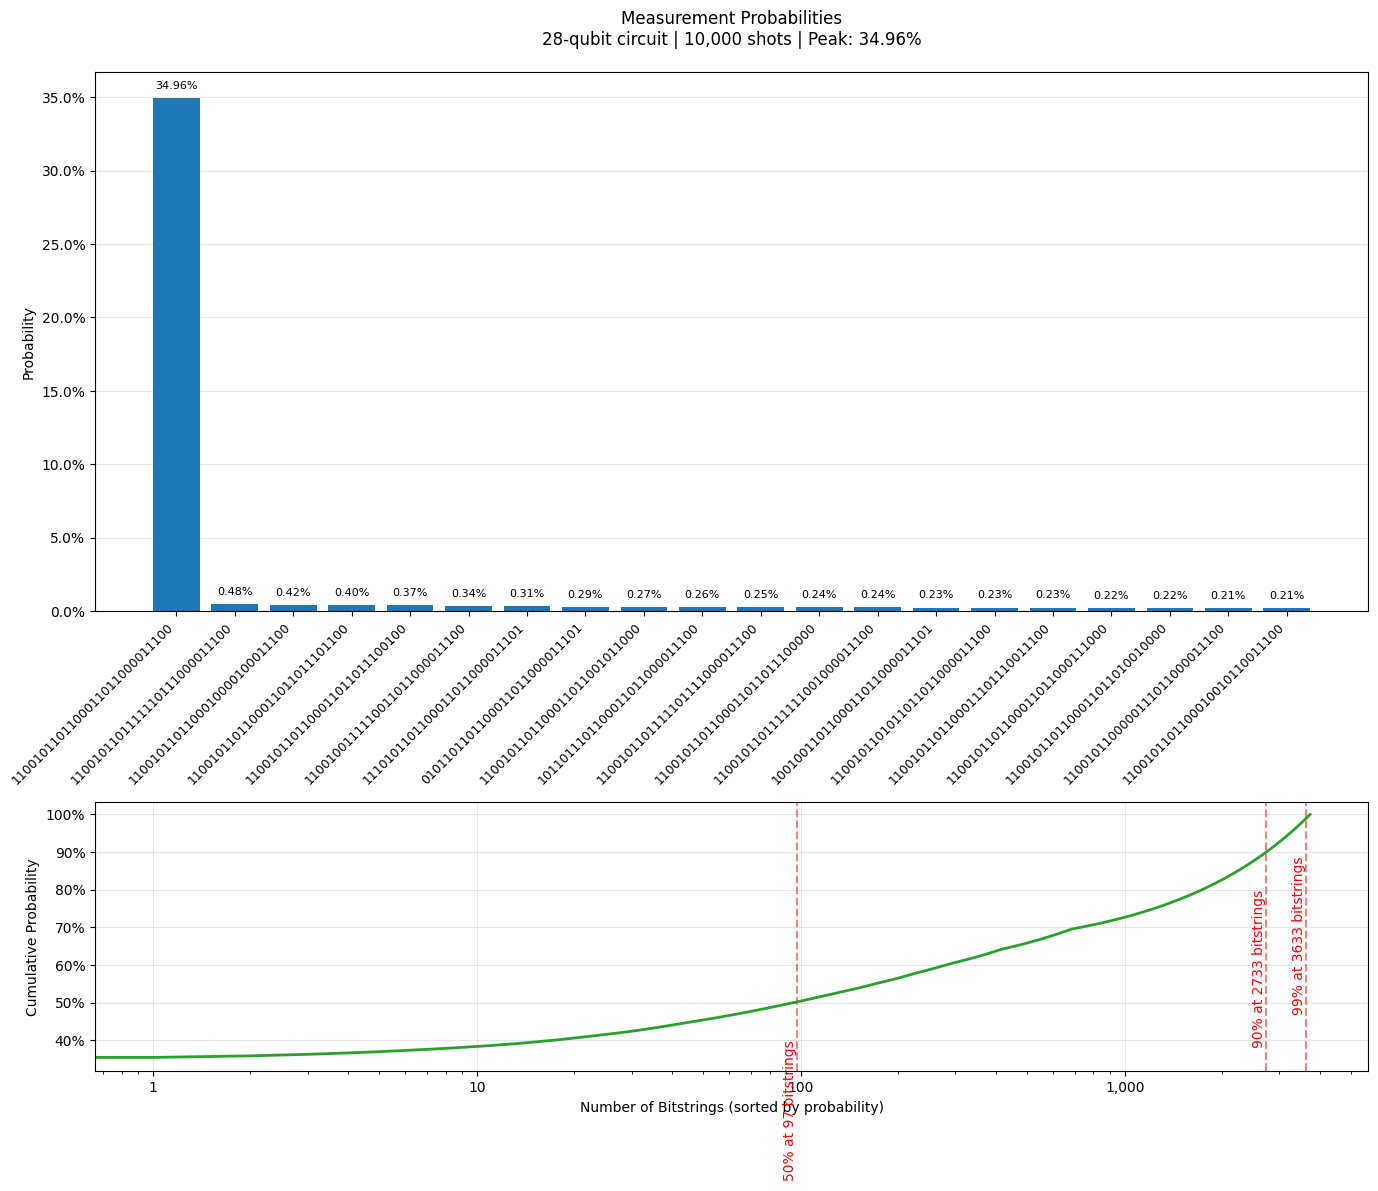


⚠️ No dominant peak found. Highest probability: 34.96%

📊 Statistics:
- Total possible outcomes: 268,435,456
- Actual observed outcomes: 3,732
- 50% of probability in first 97 bitstrings
- 90% of probability in first 2,733 bitstrings
- 99% of probability in first 3,633 bitstrings

⚠️ Analysis completed with no clear peak found


In [7]:
import bluequbit
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, List
import time
from matplotlib.ticker import PercentFormatter, FuncFormatter
from datetime import datetime

class QuantumCircuitAnalyzer:
    def __init__(self, bluequbit_token: Optional[str] = None):
        """Initialize analyzer with optional BlueQubit access"""
        self.bq = None
        if bluequbit_token:
            try:
                self.bq = bluequbit.init(bluequbit_token)
                print("🔵 BlueQubit initialized successfully")
            except Exception as e:
                print(f"⚠️ BlueQubit initialization failed: {e}. Using local simulator.")

        self.circuit = None
        self.results = None
        self.job_result = None
        self.probabilities = None

    def _calculate_probabilities(self) -> None:
        """Calculate probabilities from results and sort by probability."""
        if not self.results:
            raise ValueError("No results available to calculate probabilities")

        # Calculate total shots
        total_shots = sum(self.results.values())

        # Convert counts to probabilities
        probabilities = {
            bitstring: count / total_shots
            for bitstring, count in self.results.items()
        }

        # Sort by probability in descending order
        self.probabilities = sorted(
            probabilities.items(),
            key=lambda x: x[1],
            reverse=True
        )

    def load_qasm_circuit(self, qasm_file_path: str) -> QuantumCircuit:
        """Load and prepare quantum circuit from QASM file"""
        self.circuit = QuantumCircuit.from_qasm_file(qasm_file_path)

        # Check for existing measurements using count_ops
        if 'measure' not in self.circuit.count_ops():
            self.circuit.measure_all()

        print(f"🌀 Loaded {self.circuit.num_qubits}-qubit circuit with {len(self.circuit)} gates")
        return self.circuit

    def execute_circuit(self, shots: int = 10000, device: str = 'cpu') -> Dict[str, float]:
        """Execute circuit on BlueQubit or local simulator"""
        if self.bq:
            print("⚡ Using BlueQubit for accelerated execution...")
            self.job_result = self.bq.run(self.circuit, device=device, shots=shots)
            print(f"📦 Job submitted (ID: {self.job_result.job_id})")

            timeout = 600  # 10 minutes for large circuits
            start_time = time.time()
            poll_interval = 5  # Start with a smaller interval

            while not self.job_result.ok:
                current_time = datetime.utcnow().strftime('%H:%M:%S UTC')
                print(f"🕒 {current_time} - Waiting for job completion... "
                      f"Estimated runtime: {self.job_result.estimated_runtime / 1000:.1f}s")

                if time.time() - start_time > timeout:
                    raise TimeoutError("Job execution timed out")

                time.sleep(poll_interval)
                poll_interval = min(poll_interval * 2, 30)  # Exponential backoff up to 30 seconds
                # Refresh job status
                self.job_result = self.bq.get_job(self.job_result.job_id)

            print(f"✅ Completed in {self.job_result.run_time_ms} ms")
            self.results = self.job_result.get_counts()
        else:
            print("⚙️ Using local Qiskit simulator...")
            from qiskit_aer import AerSimulator
            simulator = AerSimulator()
            job = simulator.run(self.circuit, shots=shots)
            self.results = job.result().get_counts()

        self._calculate_probabilities()
        return self.results

    def analyze_distribution(self, confidence: float = 0.5) -> Tuple[Optional[str], float]:
        """Analyze the probability distribution for significant peaks"""
        if not self.probabilities:
            raise ValueError("No results available")

        max_bitstring, max_prob = self.probabilities[0]

        if len(self.probabilities) > 1:
            second_prob = self.probabilities[1][1]
            if (max_prob - second_prob) >= (1 - confidence):
                return max_bitstring, max_prob

        return None, max_prob

    def visualize_results(self, top_n: int = 15) -> None:
        """Create comprehensive visualization of results"""
        if not self.probabilities:
            raise ValueError("No results to visualize")

        total_shots = sum(self.results.values())
        peak_bitstring, peak_prob = self.analyze_distribution()

        # Precompute data for plotting
        top_bitstrings = [p[0] for p in self.probabilities[:top_n]]
        top_probs = [p[1] for p in self.probabilities[:top_n]]
        colors = ['#1f77b4'] * top_n
        if peak_bitstring and peak_bitstring in top_bitstrings:
            peak_idx = top_bitstrings.index(peak_bitstring)
            colors[peak_idx] = '#ff7f0e'

        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12),
                                       gridspec_kw={'height_ratios': [2, 1]})

        # Main probability plot
        bars = ax1.bar(top_bitstrings, top_probs, color=colors)
        ax1.set_xticks(range(len(top_bitstrings)))
        ax1.set_xticklabels(top_bitstrings, rotation=45, ha='right', fontsize=9)
        ax1.set_ylabel('Probability', fontsize=10)

        # Add probability labels
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2., height + 0.005,
                     f'{height:.2%}', ha='center', va='bottom', fontsize=8)

        ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
        title_text = (f"Measurement Probabilities\n"
                      f"{self.circuit.num_qubits}-qubit circuit | {total_shots:,} shots | "
                      f"Peak: {peak_prob:.2%}" +
                      (f" ({peak_bitstring})" if peak_bitstring else ""))
        ax1.set_title(title_text, pad=20)
        ax1.grid(axis='y', alpha=0.3)
        ax1.set_axisbelow(True)

        # Cumulative probability plot
        all_probs = [p[1] for p in self.probabilities]
        cumulative = np.cumsum(all_probs)

        thresholds = {0.5: '50%', 0.9: '90%', 0.99: '99%'}
        for thresh, label in thresholds.items():
            idx = np.argmax(cumulative >= thresh) + 1
            ax2.axvline(idx, color='r', linestyle='--', alpha=0.5)
            ax2.text(idx, thresh - 0.1, f"{label} at {idx} bitstrings",
                     rotation=90, va='top', ha='right', color='r')

        ax2.plot(cumulative, color='#2ca02c', linewidth=2)
        ax2.set_xlabel('Number of Bitstrings (sorted by probability)', fontsize=10)
        ax2.set_ylabel('Cumulative Probability', fontsize=10)
        ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax2.grid(alpha=0.3)

        if len(all_probs) > 100:
            ax2.set_xscale('log')
            ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

        plt.tight_layout()
        plt.show()

    def full_analysis(self, qasm_file: str, shots: int = 20000) -> Optional[str]:
        """Complete analysis workflow"""
        try:
            print("\n" + "="*50)
            print(f"🔍 Analyzing {qasm_file} with {shots:,} shots")
            print("="*50)

            self.load_qasm_circuit(qasm_file)
            self.execute_circuit(shots=shots)

            peak_bitstring, peak_prob = self.analyze_distribution()
            self.visualize_results(top_n=20)

            if peak_bitstring:
                print(f"\n🎯 Found peaked bitstring: {peak_bitstring} (Probability: {peak_prob:.2%})")
            else:
                print(f"\n⚠️ No dominant peak found. Highest probability: {peak_prob:.2%}")

            # Show additional statistics
            total_outcomes = len(self.probabilities)
            print(f"\n📊 Statistics:")
            print(f"- Total possible outcomes: {2**self.circuit.num_qubits:,}")
            print(f"- Actual observed outcomes: {total_outcomes:,}")

            # Calculate probability concentration
            cum_probs = np.cumsum([p[1] for p in self.probabilities])
            for thresh in [0.5, 0.9, 0.99]:
                idx = np.argmax(cum_probs >= thresh) + 1
                print(f"- {thresh:.0%} of probability in first {idx:,} bitstrings")

            return peak_bitstring

        except Exception as e:
            print(f"\n❌ Error during analysis: {str(e)}")
            return None

# Example Usage
if __name__ == "__main__":
    # Initialize analyzer (add your BlueQubit token if available)
    analyzer = QuantumCircuitAnalyzer(bluequbit_token="ATXjJag17q0aTEnFyOUX3UPBejxCuDTr")

    # Run complete analysis
    result = analyzer.full_analysis(
        qasm_file="/P2_swift_rise.qasm",
        shots=10000  # More shots for better statistics on large circuits
    )

    if result:
        print("\n✅ Analysis completed successfully!")
    else:
        print("\n⚠️ Analysis completed with no clear peak found")

# Problem 3: Sharp Peak


[BQ-PYTHON-SDK][WARNING] - Beta version 0.12.0b1 of BlueQubit Python SDK is being used.


🔵 BlueQubit initialized successfully

🔍 Analyzing /P3__sharp_peak.qasm with 10,000 shots
🌀 Loaded 44-qubit circuit with 622 gates
⚡ Using BlueQubit for accelerated execution...
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GHHaXGCeUkgblFPd, device: mps.cpu, run status: RUNNING, created on: 2025-04-12 18:58:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 44


INFO:bluequbit-python-sdk: - Submitted: Job ID: GHHaXGCeUkgblFPd, device: mps.cpu, run status: RUNNING, created on: 2025-04-12 18:58:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 44


📦 Job submitted (ID: GHHaXGCeUkgblFPd)
✅ Completed in 500984 ms


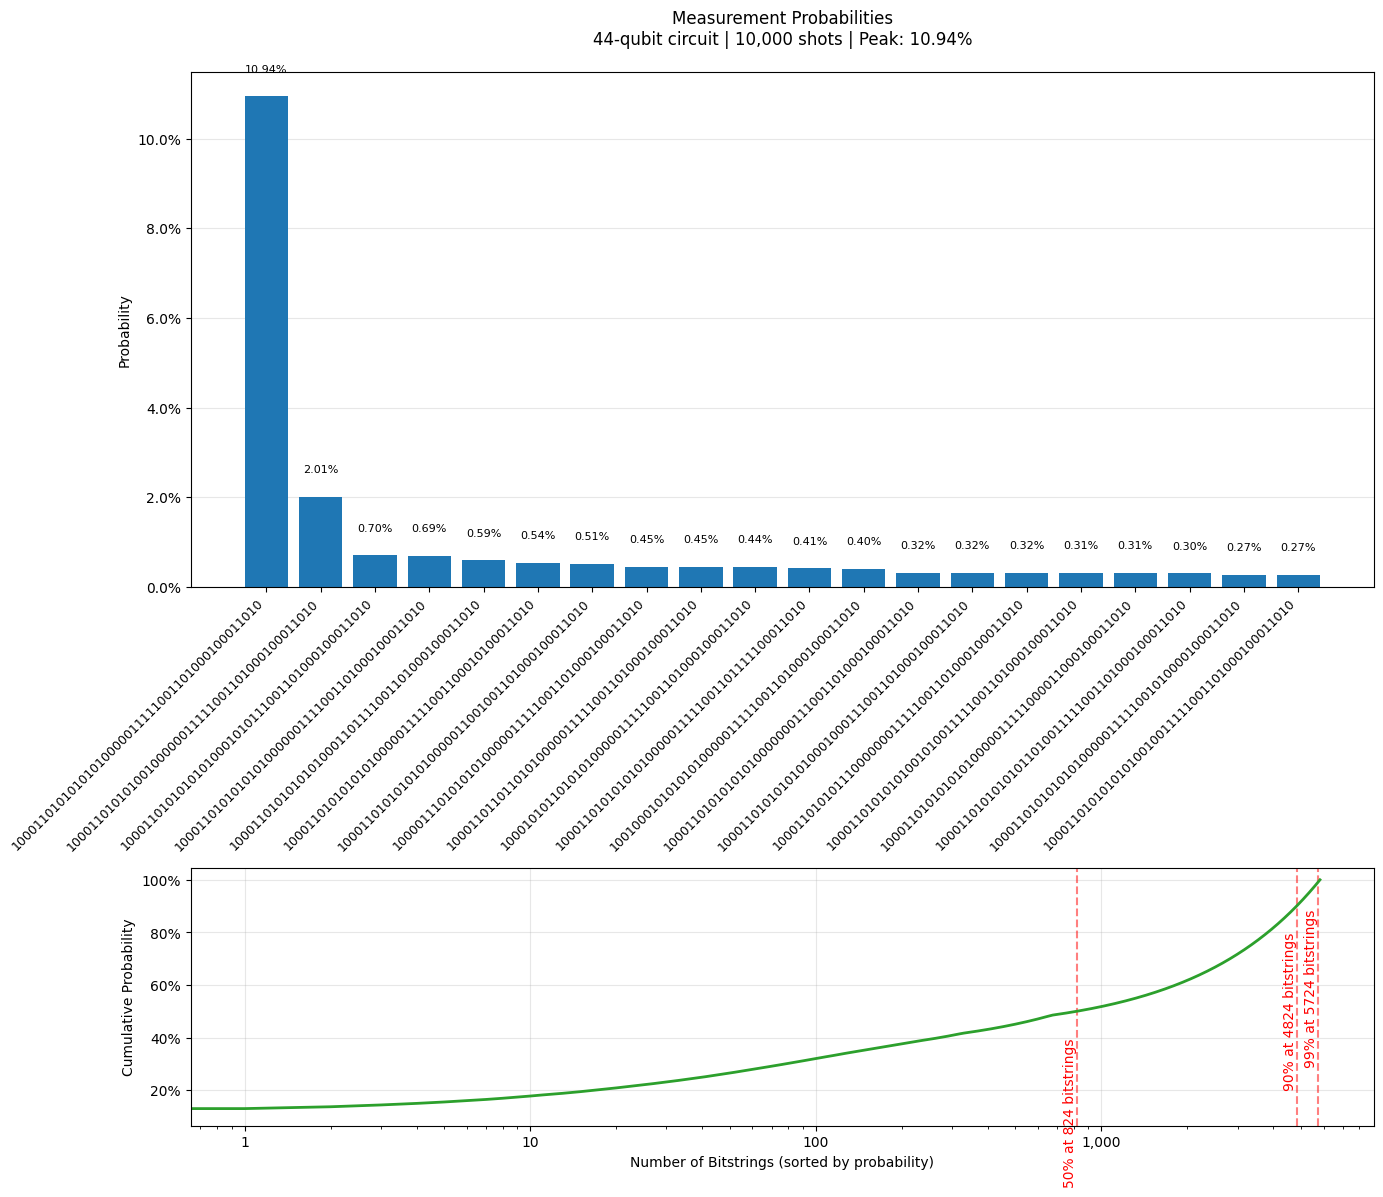


⚠️ No dominant peak found. Highest probability: 10.94%

📊 Statistics:
- Total possible outcomes: 17,592,186,044,416
- Actual observed outcomes: 5,823
- 50% of probability in first 824 bitstrings
- 90% of probability in first 4,824 bitstrings
- 99% of probability in first 5,724 bitstrings

⚠️ Analysis completed with no clear peak found


In [5]:
import bluequbit
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, List
import time
from matplotlib.ticker import PercentFormatter, FuncFormatter
from datetime import datetime

class QuantumCircuitAnalyzer:
    def __init__(self, bluequbit_token: Optional[str] = None):
        """Initialize analyzer with optional BlueQubit access"""
        self.bq = None
        if bluequbit_token:
            try:
                self.bq = bluequbit.init(bluequbit_token)
                print("🔵 BlueQubit initialized successfully")
            except Exception as e:
                print(f"⚠️ BlueQubit initialization failed: {e}. Using local simulator.")

        self.circuit = None
        self.results = None
        self.job_result = None
        self.probabilities = None

    def _calculate_probabilities(self) -> None:
        """Calculate probabilities from results and sort by probability."""
        if not self.results:
            raise ValueError("No results available to calculate probabilities")

        # Calculate total shots
        total_shots = sum(self.results.values())

        # Convert counts to probabilities
        probabilities = {
            bitstring: count / total_shots
            for bitstring, count in self.results.items()
        }

        # Sort by probability in descending order
        self.probabilities = sorted(
            probabilities.items(),
            key=lambda x: x[1],
            reverse=True
        )

    def load_qasm_circuit(self, qasm_file_path: str) -> QuantumCircuit:
        """Load and prepare quantum circuit from QASM file"""
        self.circuit = QuantumCircuit.from_qasm_file(qasm_file_path)

        # Check for existing measurements using count_ops
        if 'measure' not in self.circuit.count_ops():
            self.circuit.measure_all()

        print(f"🌀 Loaded {self.circuit.num_qubits}-qubit circuit with {len(self.circuit)} gates")
        return self.circuit

    def execute_circuit(self, shots: int = 10000, device: str = 'mps.cpu') -> Dict[str, float]:
        """Execute circuit on BlueQubit or local simulator"""
        if self.bq:
            print("⚡ Using BlueQubit for accelerated execution...")
            self.job_result = self.bq.run(self.circuit, device=device, shots=shots)
            print(f"📦 Job submitted (ID: {self.job_result.job_id})")

            timeout = 600  # 10 minutes for large circuits
            start_time = time.time()
            poll_interval = 5  # Start with a smaller interval

            while not self.job_result.ok:
                current_time = datetime.utcnow().strftime('%H:%M:%S UTC')
                print(f"🕒 {current_time} - Waiting for job completion... "
                      f"Estimated runtime: {self.job_result.estimated_runtime / 1000:.1f}s")

                if time.time() - start_time > timeout:
                    raise TimeoutError("Job execution timed out")

                time.sleep(poll_interval)
                poll_interval = min(poll_interval * 2, 30)  # Exponential backoff up to 30 seconds
                # Refresh job status
                self.job_result = self.bq.get_job(self.job_result.job_id)

            print(f"✅ Completed in {self.job_result.run_time_ms} ms")
            self.results = self.job_result.get_counts()
        else:
            print("⚙️ Using local Qiskit simulator...")
            from qiskit_aer import AerSimulator
            simulator = AerSimulator()
            job = simulator.run(self.circuit, shots=shots)
            self.results = job.result().get_counts()

        self._calculate_probabilities()
        return self.results

    def analyze_distribution(self, confidence: float = 0.5) -> Tuple[Optional[str], float]:
        """Analyze the probability distribution for significant peaks"""
        if not self.probabilities:
            raise ValueError("No results available")

        max_bitstring, max_prob = self.probabilities[0]

        if len(self.probabilities) > 1:
            second_prob = self.probabilities[1][1]
            if (max_prob - second_prob) >= (1 - confidence):
                return max_bitstring, max_prob

        return None, max_prob

    def visualize_results(self, top_n: int = 15) -> None:
        """Create comprehensive visualization of results"""
        if not self.probabilities:
            raise ValueError("No results to visualize")

        total_shots = sum(self.results.values())
        peak_bitstring, peak_prob = self.analyze_distribution()

        # Precompute data for plotting
        top_bitstrings = [p[0] for p in self.probabilities[:top_n]]
        top_probs = [p[1] for p in self.probabilities[:top_n]]
        colors = ['#1f77b4'] * top_n
        if peak_bitstring and peak_bitstring in top_bitstrings:
            peak_idx = top_bitstrings.index(peak_bitstring)
            colors[peak_idx] = '#ff7f0e'

        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12),
                                       gridspec_kw={'height_ratios': [2, 1]})

        # Main probability plot
        bars = ax1.bar(top_bitstrings, top_probs, color=colors)
        ax1.set_xticks(range(len(top_bitstrings)))
        ax1.set_xticklabels(top_bitstrings, rotation=45, ha='right', fontsize=9)
        ax1.set_ylabel('Probability', fontsize=10)

        # Add probability labels
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2., height + 0.005,
                     f'{height:.2%}', ha='center', va='bottom', fontsize=8)

        ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
        title_text = (f"Measurement Probabilities\n"
                      f"{self.circuit.num_qubits}-qubit circuit | {total_shots:,} shots | "
                      f"Peak: {peak_prob:.2%}" +
                      (f" ({peak_bitstring})" if peak_bitstring else ""))
        ax1.set_title(title_text, pad=20)
        ax1.grid(axis='y', alpha=0.3)
        ax1.set_axisbelow(True)

        # Cumulative probability plot
        all_probs = [p[1] for p in self.probabilities]
        cumulative = np.cumsum(all_probs)

        thresholds = {0.5: '50%', 0.9: '90%', 0.99: '99%'}
        for thresh, label in thresholds.items():
            idx = np.argmax(cumulative >= thresh) + 1
            ax2.axvline(idx, color='r', linestyle='--', alpha=0.5)
            ax2.text(idx, thresh - 0.1, f"{label} at {idx} bitstrings",
                     rotation=90, va='top', ha='right', color='r')

        ax2.plot(cumulative, color='#2ca02c', linewidth=2)
        ax2.set_xlabel('Number of Bitstrings (sorted by probability)', fontsize=10)
        ax2.set_ylabel('Cumulative Probability', fontsize=10)
        ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax2.grid(alpha=0.3)

        if len(all_probs) > 100:
            ax2.set_xscale('log')
            ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

        plt.tight_layout()
        plt.show()

    def full_analysis(self, qasm_file: str, shots: int = 20000) -> Optional[str]:
        """Complete analysis workflow"""
        try:
            print("\n" + "="*50)
            print(f"🔍 Analyzing {qasm_file} with {shots:,} shots")
            print("="*50)

            self.load_qasm_circuit(qasm_file)
            self.execute_circuit(shots=shots)

            peak_bitstring, peak_prob = self.analyze_distribution()
            self.visualize_results(top_n=20)

            if peak_bitstring:
                print(f"\n🎯 Found peaked bitstring: {peak_bitstring} (Probability: {peak_prob:.2%})")
            else:
                print(f"\n⚠️ No dominant peak found. Highest probability: {peak_prob:.2%}")

            # Show additional statistics
            total_outcomes = len(self.probabilities)
            print(f"\n📊 Statistics:")
            print(f"- Total possible outcomes: {2**self.circuit.num_qubits:,}")
            print(f"- Actual observed outcomes: {total_outcomes:,}")

            # Calculate probability concentration
            cum_probs = np.cumsum([p[1] for p in self.probabilities])
            for thresh in [0.5, 0.9, 0.99]:
                idx = np.argmax(cum_probs >= thresh) + 1
                print(f"- {thresh:.0%} of probability in first {idx:,} bitstrings")

            return peak_bitstring

        except Exception as e:
            print(f"\n❌ Error during analysis: {str(e)}")
            return None

# Example Usage
if __name__ == "__main__":
    # Initialize analyzer (add your BlueQubit token if available)
    analyzer = QuantumCircuitAnalyzer(bluequbit_token="ATXjJag17q0aTEnFyOUX3UPBejxCuDTr")

    # Run complete analysis
    result = analyzer.full_analysis(
        qasm_file="/P3__sharp_peak.qasm",
        shots=10000  # More shots for better statistics on large circuits
    )

    if result:
        print("\n✅ Analysis completed successfully!")
    else:
        print("\n⚠️ Analysis completed with no clear peak found")

# Problem 4: Golden Mountain

In [11]:
import bluequbit
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, List, Union
import time
from matplotlib.ticker import PercentFormatter, FuncFormatter
from datetime import datetime
import sys
from collections import defaultdict
import warnings

class QuantumCircuitAnalyzer:
    def __init__(self, bluequbit_token: Optional[str] = None):
        """Initialize analyzer with optional BlueQubit access"""
        self.bq = None
        if bluequbit_token:
            try:
                self.bq = bluequbit.init(bluequbit_token)
                print("🔵 BlueQubit initialized successfully")
            except Exception as e:
                print(f"⚠️ BlueQubit initialization failed: {e}. Using local simulator.")

        self.circuit = None
        self.results = None
        self.job_result = None
        self.probabilities = None
        self._simulator = None

    def _calculate_probabilities(self, max_bitstrings: int = 10000) -> None:
        """Calculate probabilities from results efficiently, handling large distributions"""
        if not self.results:
            raise ValueError("No results available to calculate probabilities")

        total_shots = sum(self.results.values())

        # For large distributions, we process in chunks
        if len(self.results) > max_bitstrings:
            warnings.warn(f"Large distribution detected ({len(self.results):,} bitstrings). "
                         f"Processing top {max_bitstrings:,} by count.")

            # Get top counts efficiently without full sort
            top_items = sorted(self.results.items(), key=lambda x: -x[1])[:max_bitstrings]
            remaining_shots = total_shots - sum(v for _, v in top_items)

            # Convert to probabilities
            probabilities = {
                bitstring: count / total_shots
                for bitstring, count in top_items
            }

            # Add "other" category for remaining probability
            if remaining_shots > 0:
                probabilities["...other..."] = remaining_shots / total_shots
        else:
            probabilities = {
                bitstring: count / total_shots
                for bitstring, count in self.results.items()
            }

        # Sort by probability in descending order
        self.probabilities = sorted(
            probabilities.items(),
            key=lambda x: -x[1]
        )

    def load_qasm_circuit(self, qasm_file_path: str) -> QuantumCircuit:
        """Load and prepare quantum circuit from QASM file efficiently"""
        try:
            # Use streaming for large QASM files
            with open(qasm_file_path, 'r') as f:
                first_line = f.readline()
                if "OPENQASM" not in first_line:
                    raise ValueError("Invalid QASM file format")

            self.circuit = QuantumCircuit.from_qasm_file(qasm_file_path)

            # Check for measurements more efficiently
            has_measurements = any(op.name == 'measure'
                                 for op, _, _ in self.circuit.data)

            if not has_measurements:
                self.circuit.measure_all()

            print(f"🌀 Loaded {self.circuit.num_qubits}-qubit circuit with "
                  f"{self.circuit.size()} gates")
            return self.circuit

        except Exception as e:
            raise ValueError(f"Failed to load QASM file: {str(e)}")

    def execute_circuit(self, shots: int = 10000, device: str = 'mps.cpu') -> Dict[str, float]:
        """Execute circuit with optimized resource handling"""
        if not self.circuit:
            raise ValueError("No circuit loaded")

        # Estimate memory requirements
        if self.circuit.num_qubits > 40:
            print("⚠️ Warning: Large circuit detected. Execution may require significant resources.")

        if self.bq:
            return self._execute_on_bluequbit(shots, device)
        else:
            return self._execute_locally(shots)

    def _execute_on_bluequbit(self, shots: int, device: str) -> Dict[str, float]:
        """Optimized execution on BlueQubit"""
        print("⚡ Using BlueQubit for accelerated execution...")

        try:
            # Configure job with appropriate parameters
            job_config = {
                'device': device,
                'shots': shots,
                'optimization_level': 3,
                'memory': False  # Don't return individual shot results
            }

            self.job_result = self.bq.run(self.circuit, **job_config)
            print(f"📦 Job submitted (ID: {self.job_result.job_id})")

            timeout = 1200  # 20 minutes for large circuits
            start_time = time.time()
            last_status = time.time()
            poll_interval = 2  # Start with small interval

            while not self.job_result.ok:
                current_time = time.time()

                # Print status updates every 15 seconds
                if current_time - last_status > 15:
                    current_time_str = datetime.utcnow().strftime('%H:%M:%S UTC')
                    est_runtime = self.job_result.estimated_runtime / 1000
                    print(f"🕒 {current_time_str} - Status: {self.job_result.status} | "
                          f"Estimated runtime: {est_runtime:.1f}s")
                    last_status = current_time

                if current_time - start_time > timeout:
                    raise TimeoutError(f"Job execution timed out after {timeout} seconds")

                time.sleep(poll_interval)
                poll_interval = min(poll_interval * 1.5, 30)  # Exponential backoff

                # Refresh job status
                self.job_result = self.bq.get_job(self.job_result.job_id)

            print(f"✅ Completed in {self.job_result.run_time_ms} ms")
            self.results = self.job_result.get_counts()
            self._calculate_probabilities()
            return self.results

        except Exception as e:
            raise RuntimeError(f"BlueQubit execution failed: {str(e)}")

    def _execute_locally(self, shots: int) -> Dict[str, float]:
        """Optimized local execution with memory management"""
        print("⚙️ Using local Qiskit simulator...")

        try:
            # Lazy import to save memory
            if self._simulator is None:
                from qiskit_aer import AerSimulator
                self._simulator = AerSimulator(method='automatic')

            # Configure for large circuits
            if self.circuit.num_qubits > 30:
                print("🔧 Configuring simulator for large circuit...")
                self._simulator.set_options(
                    max_parallel_threads=0,  # Let system decide
                    max_parallel_experiments=1,
                    blocking_enable=True
                )

            # Execute in chunks if needed
            chunk_size = min(shots, 10000)  # Process in chunks of 10k shots
            full_results = defaultdict(int)

            for chunk_start in range(0, shots, chunk_size):
                current_shots = min(chunk_size, shots - chunk_start)
                job = self._simulator.run(
                    self.circuit,
                    shots=current_shots,
                    memory=False
                )

                # Process chunk results
                chunk_results = job.result().get_counts()
                for bitstring, count in chunk_results.items():
                    full_results[bitstring] += count

                # Memory cleanup
                del job

            self.results = dict(full_results)
            self._calculate_probabilities()
            return self.results

        except MemoryError:
            raise MemoryError("Insufficient memory for local execution. "
                            "Try with fewer shots or use BlueQubit.")
        except Exception as e:
            raise RuntimeError(f"Local execution failed: {str(e)}")

    def analyze_distribution(self, confidence: float = 0.5) -> Tuple[Optional[str], float]:
        """Analyze the probability distribution with optimized calculations"""
        if not self.probabilities:
            raise ValueError("No results available")

        max_bitstring, max_prob = self.probabilities[0]

        # Early exit for peaked distributions
        if max_prob >= confidence:
            return max_bitstring, max_prob

        # Only compare with next highest if needed
        if len(self.probabilities) > 1:
            second_prob = self.probabilities[1][1]
            if (max_prob - second_prob) >= (1 - confidence):
                return max_bitstring, max_prob

        return None, max_prob

    def visualize_results(self, top_n: int = 15) -> None:
        """Optimized visualization for large distributions"""
        if not self.probabilities:
            raise ValueError("No results to visualize")

        total_shots = sum(self.results.values())
        peak_bitstring, peak_prob = self.analyze_distribution()

        # Handle large distributions
        if len(self.probabilities) > 100:
            top_n = min(top_n, 20)  # Show fewer for large distributions
            show_cumulative = False  # Skip cumulative for very large distributions
        else:
            show_cumulative = True

        # Prepare data for plotting
        plot_bitstrings = []
        plot_probs = []
        colors = []

        for i, (bitstring, prob) in enumerate(self.probabilities[:top_n]):
            # Truncate long bitstrings
            display_bitstring = bitstring
            if len(bitstring) > 20:
                display_bitstring = f"{bitstring[:10]}...{bitstring[-10:]}"

            plot_bitstrings.append(display_bitstring)
            plot_probs.append(prob)

            # Highlight peak if found
            if peak_bitstring and bitstring == peak_bitstring:
                colors.append('#ff7f0e')  # Orange
            else:
                colors.append('#1f77b4')  # Blue

        # Create figure
        if show_cumulative:
            fig, (ax1, ax2) = plt.subplots(
                2, 1, figsize=(14, 12),
                gridspec_kw={'height_ratios': [2, 1]}
            )
        else:
            fig, ax1 = plt.subplots(figsize=(14, 8))

        # Main probability plot
        bars = ax1.bar(plot_bitstrings, plot_probs, color=colors)
        ax1.set_xticks(range(len(plot_bitstrings)))
        ax1.set_xticklabels(plot_bitstrings, rotation=45, ha='right', fontsize=9)
        ax1.set_ylabel('Probability', fontsize=10)

        # Add probability labels if not too many
        if top_n <= 30:
            for bar in bars:
                height = bar.get_height()
                ax1.text(
                    bar.get_x() + bar.get_width() / 2.,
                    height + 0.005,
                    f'{height:.2%}',
                    ha='center',
                    va='bottom',
                    fontsize=8
                )

        ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
        title_text = (f"Measurement Probabilities\n"
                     f"{self.circuit.num_qubits}-qubit circuit | {total_shots:,} shots | "
                     f"Peak: {peak_prob:.2%}" +
                     (f" ({peak_bitstring})" if peak_bitstring else ""))
        ax1.set_title(title_text, pad=20)
        ax1.grid(axis='y', alpha=0.3)
        ax1.set_axisbelow(True)

        # Cumulative probability plot if enabled
        if show_cumulative:
            all_probs = [p[1] for p in self.probabilities]
            cumulative = np.cumsum(all_probs)

            thresholds = {0.5: '50%', 0.9: '90%', 0.99: '99%'}
            for thresh, label in thresholds.items():
                idx = np.argmax(cumulative >= thresh) + 1
                ax2.axvline(idx, color='r', linestyle='--', alpha=0.5)
                ax2.text(
                    idx, thresh - 0.1,
                    f"{label} at {idx} bitstrings",
                    rotation=90, va='top', ha='right', color='r'
                )

            ax2.plot(cumulative, color='#2ca02c', linewidth=2)
            ax2.set_xlabel('Number of Bitstrings (sorted by probability)', fontsize=10)
            ax2.set_ylabel('Cumulative Probability', fontsize=10)
            ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
            ax2.grid(alpha=0.3)

            if len(all_probs) > 100:
                ax2.set_xscale('log')
                ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

        plt.tight_layout()
        plt.show()

    def full_analysis(self, qasm_file: str, shots: int = 20000) -> Optional[str]:
        """Complete optimized analysis workflow"""
        try:
            print("\n" + "="*50)
            print(f"🔍 Analyzing {qasm_file} with {shots:,} shots")
            print("="*50)

            # Memory monitoring
            import psutil
            start_mem = psutil.Process().memory_info().rss / 1024 / 1024
            print(f"💾 Starting memory usage: {start_mem:.1f} MB")

            self.load_qasm_circuit(qasm_file)

            # Adjust shots for very large circuits
            if self.circuit.num_qubits > 40:
                shots = min(shots, 100000)  # Cap at 100k shots
                print(f"⚡ Adjusting shots to {shots:,} for large circuit")

            self.execute_circuit(shots=shots)

            peak_bitstring, peak_prob = self.analyze_distribution()
            self.visualize_results(top_n=20)

            if peak_bitstring:
                print(f"\n🎯 Found peaked bitstring: {peak_bitstring} (Probability: {peak_prob:.2%})")
            else:
                print(f"\n⚠️ No dominant peak found. Highest probability: {peak_prob:.2%}")

            # Show additional statistics
            total_outcomes = len(self.probabilities)
            print(f"\n📊 Statistics:")
            print(f"- Total possible outcomes: {2**self.circuit.num_qubits:,}")
            print(f"- Actual observed outcomes: {total_outcomes:,}")

            # Calculate probability concentration
            cum_probs = np.cumsum([p[1] for p in self.probabilities])

            for thresh in [0.5, 0.9, 0.99]:
                idx = np.argmax(cum_probs >= thresh) + 1
                print(f"- {thresh:.0%} of probability in first {idx:,} bitstrings")

            # Memory report
            end_mem = psutil.Process().memory_info().rss / 1024 / 1024
            print(f"\n💾 Memory usage: {end_mem:.1f} MB (Δ {end_mem - start_mem:.1f} MB)")

            return peak_bitstring

        except MemoryError:
            print("\n❌ Memory error during analysis. Try with:")
            print("- Fewer shots")
            print("- A system with more RAM")
            print("- BlueQubit for remote execution")
            return None
        except Exception as e:
            print(f"\n❌ Error during analysis: {str(e)}")
            return None


# Example Usage
if __name__ == "__main__":
    # Initialize analyzer (add your BlueQubit token if available)
    analyzer = QuantumCircuitAnalyzer(bluequbit_token="ATXjJag17q0aTEnFyOUX3UPBejxCuDTr")

    # Run complete analysis
    result = analyzer.full_analysis(
        qasm_file="/P4_golden_mountain.qasm",
        shots=50000  # Adjusted for large circuits
    )

    if result:
        print("\n✅ Analysis completed successfully!")
    else:
        print("\n⚠️ Analysis completed with no clear peak found")

[BQ-PYTHON-SDK][WARNING] - Beta version 0.12.0b1 of BlueQubit Python SDK is being used.


🔵 BlueQubit initialized successfully

🔍 Analyzing /P4_golden_mountain.qasm with 50,000 shots
💾 Starting memory usage: 205.3 MB
🌀 Loaded 48-qubit circuit with 15384 gates
⚡ Adjusting shots to 50,000 for large circuit
⚠️ Warning: Large circuit detected. Execution may require significant resources.
⚡ Using BlueQubit for accelerated execution...

❌ Error during analysis: BlueQubit execution failed: BQClient.run() got an unexpected keyword argument 'optimization_level'

⚠️ Analysis completed with no clear peak found


<ipython-input-11-4260c3c85f1d>:80: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for op, _, _ in self.circuit.data)


In [12]:
from qiskit import qasm, qasm2,qasm3
from qiskit.circuit import QuantumCircuit, ClassicalRegister, Gate, library
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2 as Sampler

import numpy as np
from matplotlib import pyplot as plt

backend_name = 'ibm_torino'

service = QiskitRuntimeService(
    channel="ibm_cloud",
    instance="BlueQubit Challenge",
    token="qhuDjVuaieixTE7prHofDF-0osUdKHKqvRtwnf6GZrur"
)